# Comparison with RadVel

`simppler` is very much inspired from the RadVel package.
The goal when writing `simppler` was actually to test the underlying `simpple` package on a real use-case, and RadVel seemed like a good comparison (in part because I am familiar with its codebase).

This notebook compares `simppler` and `radvel`, on the one  hand to make migration between the two easier, and on the other hand to make sure there is no major performance difference between the two.

## Data

We will use the same model and data as in [the K2-24 tutorial](./k2-24_mcmc.ipynb), as this example was taken from RadVel tutorial.

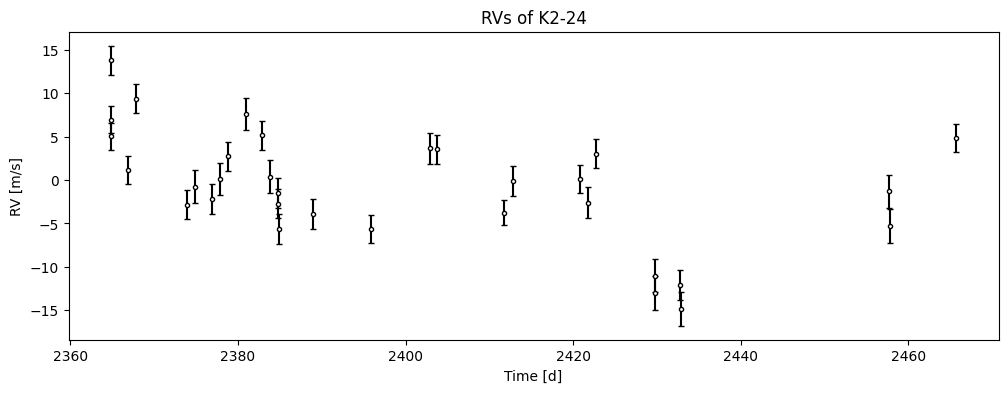

In [1]:
from pandas import read_csv
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/refs/heads/master/example_data/epic203771098.csv"
df = read_csv(url, index_col=0)


t = df.t.values
vel = df.vel.values
errvel = df.errvel.values

def plot_data():
    plt.figure(figsize=(12, 4))
    plt.errorbar(t, vel, yerr=errvel, fmt="k.", capsize=2, mfc="w", label="Data")
    plt.xlabel("Time [d]")
    plt.ylabel("RV [m/s]")
plot_data()
plt.title("RVs of K2-24")
plt.show()

## `simppler` model

First, we build the `simppler`, re-using our builder function from the K2-24 tutorial.

In [2]:
import numpy as np
import simppler.model as smod
from simpple import distributions as sdist
periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
def build_model(vary):
    if vary == "all":
        parameters = {
            "per1": sdist.Normal(periods[0], period_errs[0]),
            "tc1": sdist.Normal(t0s[0], t0_errs[0]),
            "secosw1": sdist.Uniform(-1, 1),
            "sesinw1": sdist.Uniform(-1, 1),
            "logk1": sdist.Normal(np.log(5), 10),
            "per2": sdist.Normal(periods[1], period_errs[1]),
            "tc2": sdist.Normal(t0s[1], t0_errs[1]),
            "secosw2": sdist.Uniform(-1, 1),
            "sesinw2": sdist.Uniform(-1, 1),
            "logk2": sdist.Normal(np.log(5), 10),
            "dvdt": sdist.Normal(0, 1.0),
            "curv": sdist.Normal(0, 1e-1),
            "gamma": sdist.Normal(0, 10.0),
            "jit": sdist.Normal(np.log(3), 0.5),
        }
    elif vary == "ecc":
        parameters = {
            "per1": sdist.Fixed(periods[0]),
            "tc1": sdist.Fixed(t0s[0]),
            "secosw1": sdist.Uniform(-1, 1),
            "sesinw1": sdist.Uniform(-1, 1),
            "logk1": sdist.Normal(np.log(5), 10),
            "per2": sdist.Fixed(periods[1]),
            "tc2": sdist.Fixed(t0s[1]),
            "secosw2": sdist.Uniform(-1, 1),
            "sesinw2": sdist.Uniform(-1, 1),
            "logk2": sdist.Normal(np.log(5), 10),
            "dvdt": sdist.Normal(0, 1.0),
            "curv": sdist.Normal(0, 1e-1),
            "gamma": sdist.Normal(0, 10.0),
            "jit": sdist.Normal(np.log(3), 0.5),
        }
    else:
        parameters = {
            "per1": sdist.Fixed(periods[0]),
            "tc1": sdist.Fixed(t0s[0]),
            "secosw1": sdist.Fixed(0.01),
            "sesinw1": sdist.Fixed(0.01),
            "logk1": sdist.Normal(np.log(5), 10),
            "per2": sdist.Fixed(periods[1]),
            "tc2": sdist.Fixed(t0s[1]),
            "secosw2": sdist.Fixed(0.01),
            "sesinw2": sdist.Fixed(0.01),
            "logk2": sdist.Normal(np.log(5), 10),
            "dvdt": sdist.Normal(0, 1.0),
            "curv": sdist.Normal(0, 1e-1),
            "gamma": sdist.Normal(0, 10.0),
            "jit": sdist.Normal(np.log(3), 0.5),
        }
    tmod = np.linspace(t.min() - 5, t.max() + 5, num=1000)
    time_base = 2420
    return smod.RVModel(parameters, 2, t, vel, errvel, basis="per tc secosw sesinw logk", tmod=tmod, time_base=time_base)

simpple_model = build_model("circular")

/home/vandal/miniforge3/envs/simppler/lib/python3.13/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


We will also optimize the model to ensure that we have an easy starting point for the MCMC, as our goal here is not to test sampling efficiency.

In [3]:
test_p = {"per1": periods[0], "tc1": t0s[0], "secosw1": 0.01, "sesinw1": 0.01, "logk1": 1.1}
test_p |= {"per2": periods[1], "tc2": t0s[1], "secosw2": 0.01, "sesinw2": 0.01, "logk2": 1.1}
test_p |= {"gamma": -10, "dvdt": -0.02, "curv": 0.01, "jit": 1.0}


from scipy.optimize import minimize

vary_p = {p: v for p, v in test_p.items() if p in simpple_model.vary_p}
res = minimize(lambda p: - simpple_model.log_prob(p), np.array(list(vary_p.values())), method="Nelder-Mead")
opt_p = dict(zip(simpple_model.keys(), res.x))

## Converting from `simppler` to RadVel

`simppler` models have a method allowing us to convert the model directly to a `radvel.Posterior` object.

In [4]:
radvel_post = simpple_model.to_radvel()

In [5]:
vary_p_arr = [test_p[k] for k in simpple_model.keys()]
radvel_post.set_vary_params(vary_p_arr)
print(radvel_post)

parameter                     value      vary
per1                        20.8851      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           1.1       True
per2                        42.3633      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                           1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma                           -10       True
jit                               1       True
tp1                         2070.19           
e1                           0.0002           
w1                         0.785398           
k1                          3.00417           
tp2                         2077.33           
e2                           0.0002           
w2            

Let us compare the output from the two models

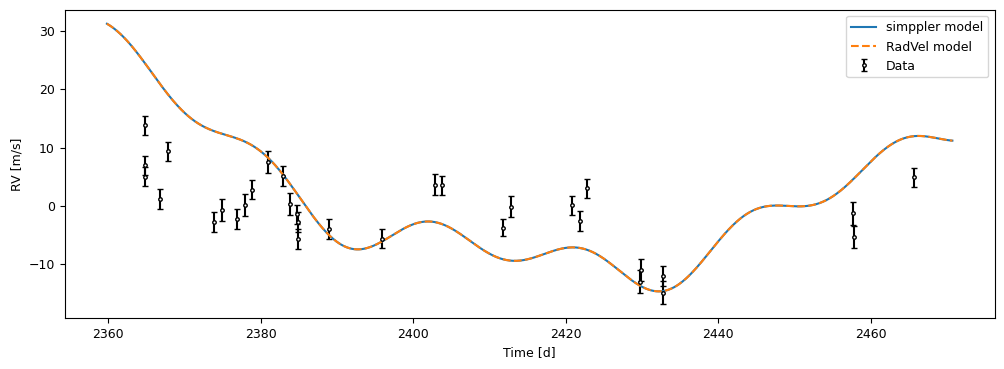

In [6]:
plot_data()
plt.plot(simpple_model.tmod, simpple_model.forward(test_p, simpple_model.tmod), label="simppler model")
plt.plot(
  simpple_model.tmod, radvel_post.model(simpple_model.tmod) + radvel_post.params["gamma"].value, "--", label="RadVel model"
)
plt.legend()
plt.show()

That looks great! We can now compare the execution speed of the two models.

## Speed comparison

We do not expect a big performance difference between `simppler` and `radvel`: the former uses the keplerian solver from the latter.
However, some performance cost may be associated with the parameter handling or how the distributions are written (this is how I realized that Scipy distributions were quite slow).

In [7]:
from timeit import timeit

timeit("radvel_post.logprob_array(vary_p_arr)", globals=globals())

185.18081044399878

For `simppler`, we will test with dict and array inputs to see if there is a difference.

In [8]:
timeit("simpple_model.log_prob(test_p)", globals=globals())

168.72106805899966

In [9]:
timeit("simpple_model.log_prob(vary_p_arr)", globals=globals())

187.2413174889989

As expected, everything here is fairly similar.

## Sampling comparison

We can also compare the sampling results from the two packaes to ensure that they are consistent.

### `simppler` sampling

In [10]:
import emcee

nwalkers = 50
nsteps = 10_000
ndim = simpple_model.ndim
sampler = emcee.EnsembleSampler(nwalkers, ndim, simpple_model.log_prob)

In [11]:
rng = np.random.default_rng()
p0 = res.x + 1e-4 * rng.normal(size=(nwalkers, ndim))
_ = sampler.run_mcmc(p0, nsteps, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:36<00:00, 103.86it/s]


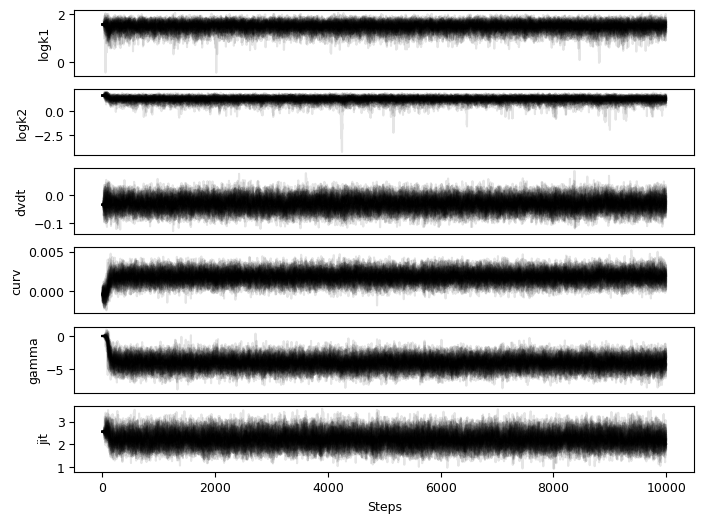

In [12]:
from simpple.plot import chainplot
chainplot(sampler.get_chain(), labels=simpple_model.keys())
plt.show()

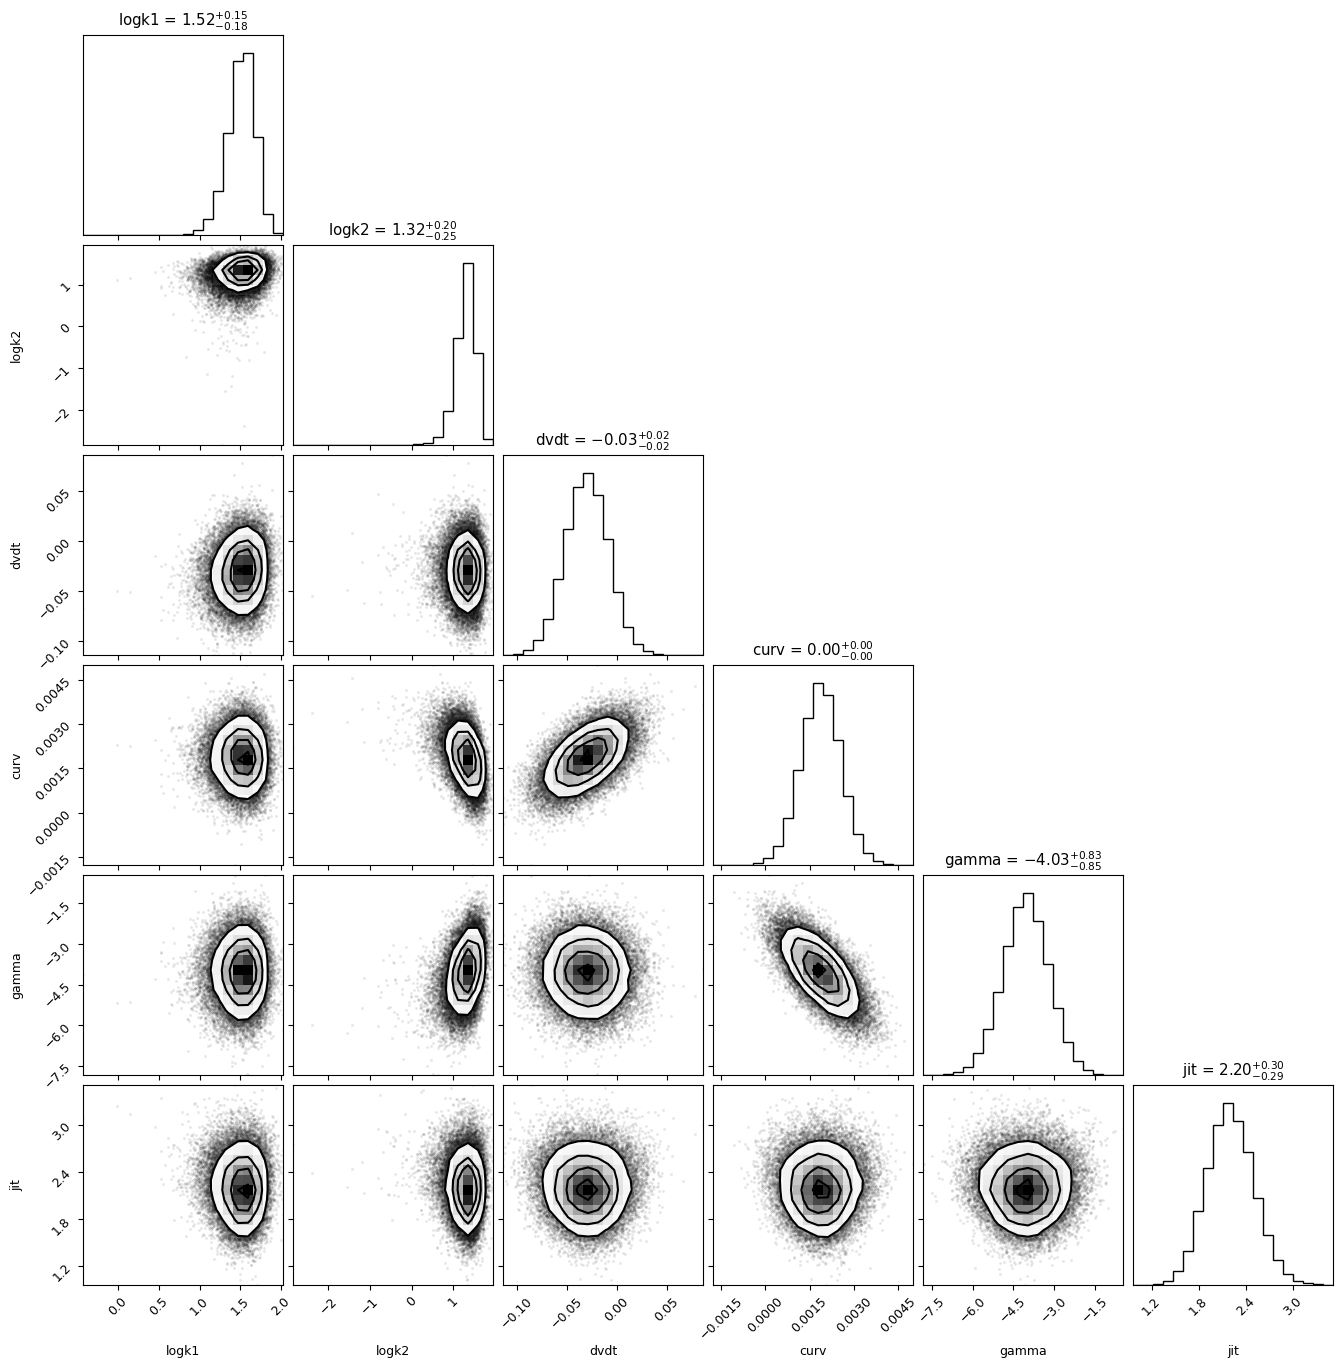

In [13]:
import corner
simppler_chains = sampler.get_chain(discard=2000, flat=True, thin=10)
corner.corner(simppler_chains, labels=simpple_model.keys(), show_titles=True)
plt.show()

### `radvel` sampling

In [14]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, radvel_post.logprob_array)

In [15]:
_ = sampler.run_mcmc(p0, nsteps, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:38<00:00, 101.02it/s]


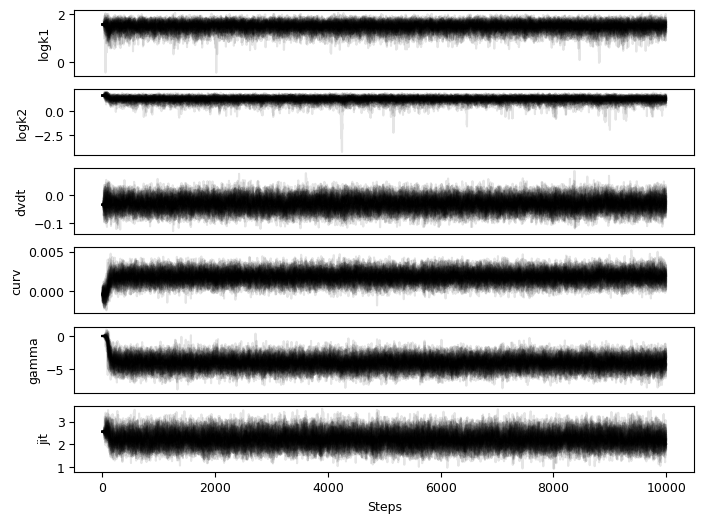

In [16]:
from simpple.plot import chainplot
chainplot(sampler.get_chain(), labels=radvel_post.name_vary_params())
plt.show()

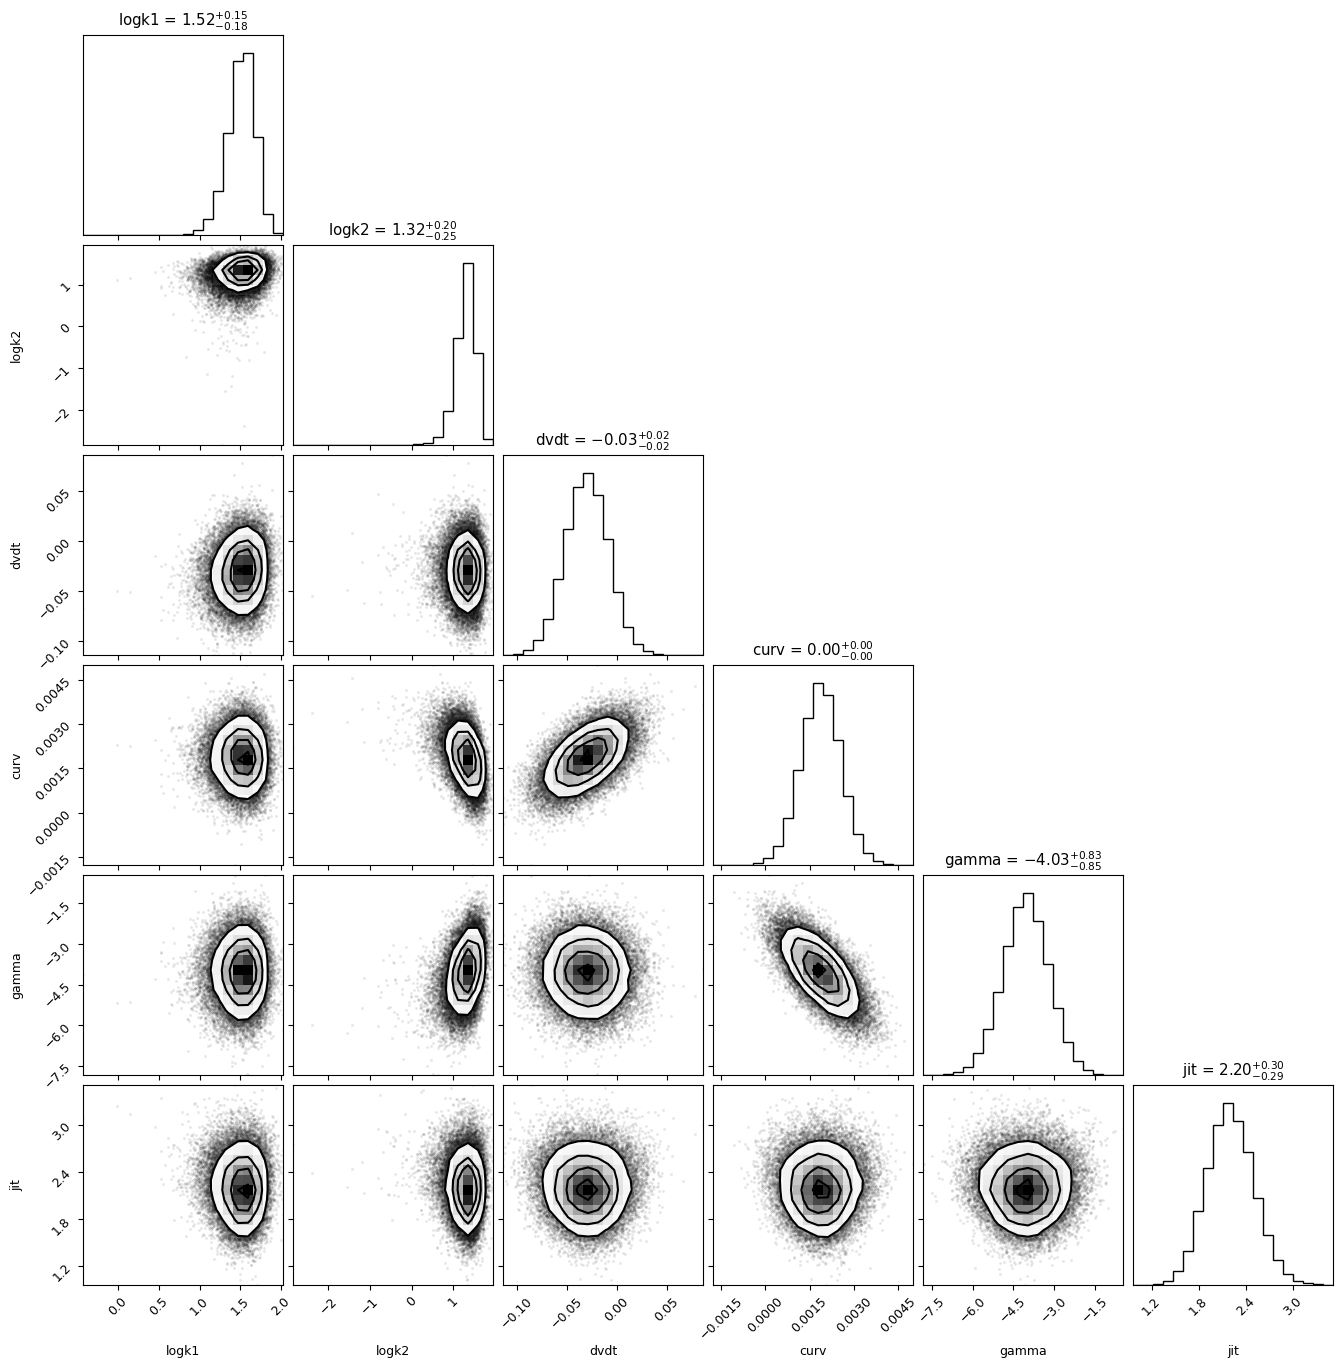

In [17]:
import corner
radvel_chains = sampler.get_chain(discard=2000, flat=True, thin=10)
corner.corner(radvel_chains, labels=radvel_post.name_vary_params(), show_titles=True)
plt.show()

### Combined corner plot


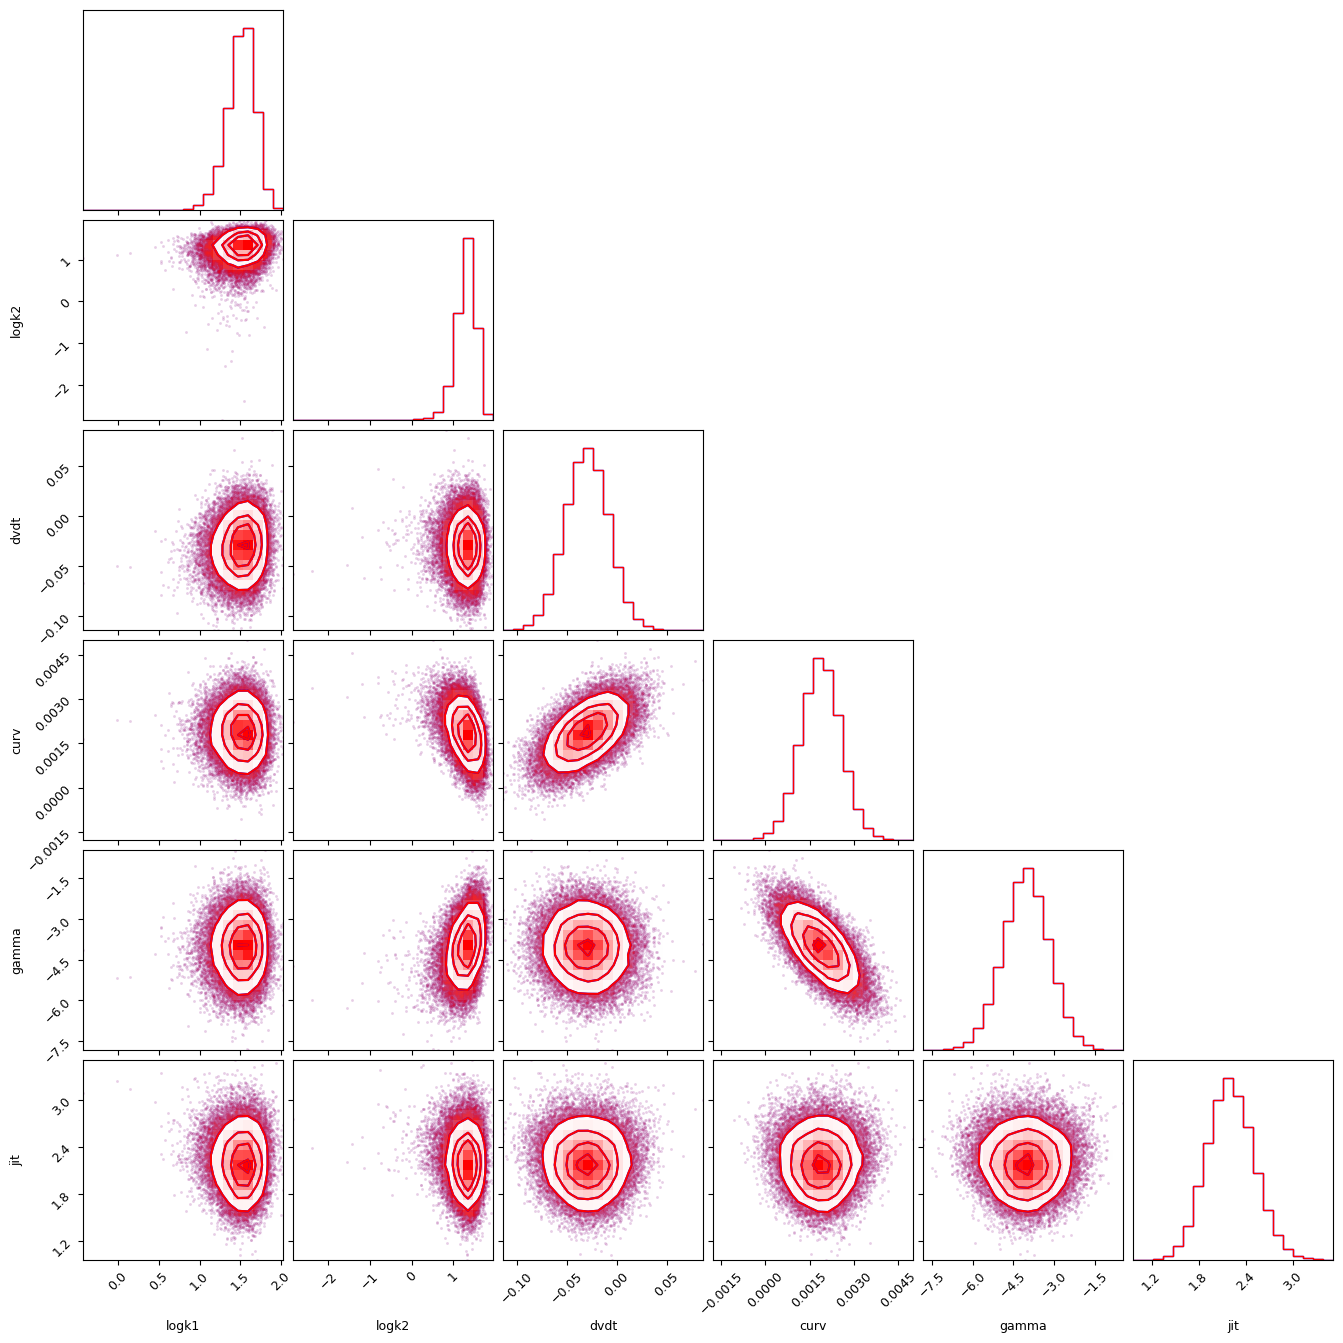

In [18]:
import corner
fig = corner.corner(radvel_chains, labels=radvel_post.name_vary_params(), color="b")
corner.corner(simppler_chains, color="r", fig=fig)
plt.show()